# Explainable ResNet on CheXpert dataset PoC

In [13]:
import src.datasets as datasets
import src.models as models
import src.wrappers as wrappers
import matplotlib.pyplot as plt
%matplotlib inline

## Dataset sanity check

In [2]:
data_module = datasets.CheXpertLitDataModule("CheXpert-v1.0-small")

Loaded 223414 samples from CheXpert-v1.0-small\train.csv
Labels: (223414, 14)
Image paths: (223414,)
Loaded 234 samples from CheXpert-v1.0-small\valid.csv
Labels: (234, 14)
Image paths: (234,)


tensor([                   1, -9223372036854775808, -9223372036854775808,
        -9223372036854775808, -9223372036854775808, -9223372036854775808,
        -9223372036854775808, -9223372036854775808, -9223372036854775808,
                           0, -9223372036854775808, -9223372036854775808,
        -9223372036854775808,                    1])


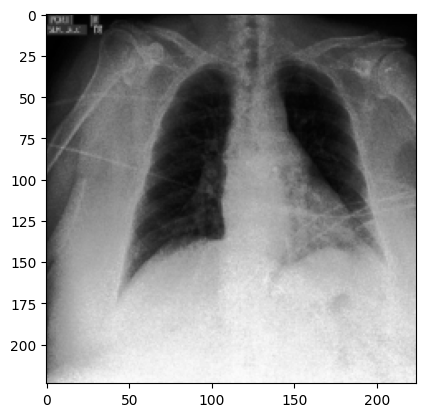

In [3]:
from torchvision import transforms
image, labels = data_module.train_dataset[0]
image = transforms.ToPILImage()(image)
print(labels)
plt.imshow(image, cmap='gray')
plt.show()

## Model sanity check

In [5]:
image, labels = data_module.train_dataset[1]
model = models.ResNetCheXpert(num_classes=14)

y_hat = model(image.unsqueeze(0))
print(y_hat.shape)
print(y_hat)

torch.Size([1, 14])
tensor([[-0.2478,  0.0317, -0.0658,  0.9817, -1.2084, -0.3627, -0.3992,  0.0930,
          0.3400,  0.3047,  0.0552, -0.2074,  0.0087, -0.1744]],
       grad_fn=<AddmmBackward0>)


# Fine-Tuning the model

In [1]:
import src.wrappers as wrappers
import src.models as models
import src.datasets as datasets
from pytorch_lightning import Trainer
from pytorch_lightning.loggers import  CSVLogger
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
import torch

In [8]:
model = wrappers.CheXpertLitModel()
logger = CSVLogger("logs", name="resnet-chexpert")
checkpoint_callback = ModelCheckpoint(monitor='val_auroc', save_top_k=2, mode='max', dirpath=f"checkpoints")
early_stop_callback = EarlyStopping(monitor='val_auroc', patience=3, mode='max')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.set_float32_matmul_precision('medium')
trainer = Trainer(max_epochs=10, logger=logger, callbacks=[checkpoint_callback, early_stop_callback], accelerator='gpu', devices=1)
data_module = datasets.CheXpertLitDataModule("CheXpert-v1.0-small", batch_size=64)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Loaded 223414 samples from CheXpert-v1.0-small\train.csv
Labels: (223414, 14)
Image paths: (223414,)
Loaded 234 samples from CheXpert-v1.0-small\valid.csv
Labels: (234, 14)
Image paths: (234,)


In [9]:
trainer.fit(model, data_module)

c:\Users\micha\AppData\Local\Programs\Python\Python311\Lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:652: Checkpoint directory G:\psim-projekt\poc\checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type              | Params | Mode 
--------------------------------------------------------
0 | model     | ResNetCheXpert    | 23.5 M | train
1 | criterion | BCEWithLogitsLoss | 0      | train
2 | metric    | MultilabelAUROC   | 0      | train
--------------------------------------------------------
23.5 M    Trainable params
0         Non-trainable params
23.5 M    Total params
94.147    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\micha\AppData\Local\Programs\Python\Python311\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:419: Consider setting `persistent_workers=True` in 'val_dataloader' to speed up the dataloader worker initialization.
c:\Users\micha\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchmetrics\utilities\prints.py:43: UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
  warnings.warn(*args, **kwargs)  # noqa: B028
c:\Users\micha\AppData\Local\Programs\Python\Python311\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:419: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

c:\Users\micha\AppData\Local\Programs\Python\Python311\Lib\site-packages\pytorch_lightning\trainer\call.py:54: Detected KeyboardInterrupt, attempting graceful shutdown...


# Using gradient CAM for explainability

In [55]:
import matplotlib.pyplot as plt
%matplotlib inline

Load model checkpoint

In [56]:
import os, re, torch
import src.models as models
import src.wrappers as wrappers
import src.datasets as datasets

# Load the latest checkpoint
checkpoint_dir = "checkpoints"
checkpoints = os.listdir(checkpoint_dir)
checkpoint = torch.load(os.path.join(checkpoint_dir, checkpoints[-1]), weights_only=False)
model = wrappers.CheXpertLitModel()
model.load_state_dict(checkpoint['state_dict'])
model.eval()

# Get the eval dataset
data_module = datasets.CheXpertLitDataModule("CheXpert-v1.0-small")
val_dataset = data_module.val_dataset

Loaded 223414 samples from CheXpert-v1.0-small\train.csv
Labels: (223414, 14)
Image paths: (223414,)
Loaded 234 samples from CheXpert-v1.0-small\valid.csv
Labels: (234, 14)
Image paths: (234,)


Run model on example sample

No Finding: 0 -> 0.00 -> 0
Enlarged Cardiomediastinum: 0 -> 0.00 -> 0
Cardiomegaly: 0 -> 0.00 -> 0
Lung Opacity: 0 -> 0.00 -> 0
Lung Lesion: 0 -> 0.00 -> 0
Edema: 0 -> 0.00 -> 0
Consolidation: 0 -> 0.00 -> 0
Pneumonia: 0 -> 0.00 -> 0
Atelectasis: 0 -> 0.00 -> 0
Pneumothorax: 0 -> 0.00 -> 0
Pleural Effusion: 0 -> 0.00 -> 0
Pleural Other: 0 -> 0.00 -> 0
Fracture: 0 -> 0.00 -> 0
Support Devices: 1 -> 0.00 -> 0
tensor([[-175346.2500, -175070.7500, -175122.4062, -174088.9844, -175386.9531,
         -174718.6250, -174585.0781, -175340.8281, -175003.2500, -174768.2969,
         -173578.1406, -175425.9219, -175340.1250, -173887.4531]],
       grad_fn=<AddmmBackward0>)


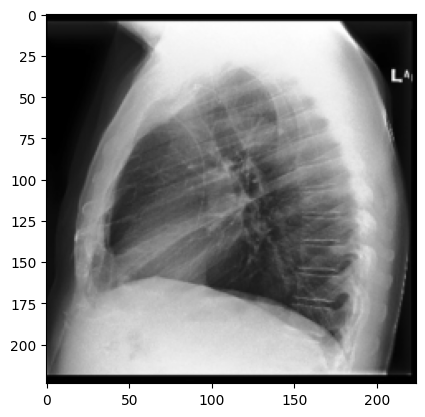

In [57]:
from torchvision import transforms

def display_results(image, logits, labels, label_names, treshold=0.5):
    propabilities = torch.sigmoid(logits)
    predictions = (propabilities >= treshold).int()
    for i, (label, propability, prediction) in enumerate(zip(labels, propabilities[0], predictions[0])):
        print(f"{label_names[i]}: {label} -> {propability:.2f} -> {prediction}")
    
    image_pil = transforms.ToPILImage()(image)
    plt.imshow(image_pil, cmap='gray')
    
def get_results(image, logits, treshold=0.5):
    propabilities = torch.sigmoid(logits)
    predictions = (propabilities >= treshold).int()
    return propabilities, predictions

image, labels = val_dataset[2]
logits = model(image.unsqueeze(0))
label_names = val_dataset.label_names
display_results(image, logits, labels, label_names)
print(logits)

Compute Gradient CAM

In [58]:
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image, preprocess_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from PIL import Image
from torchvision import transforms
import numpy as np

target_layers = [model.model.model.layer4[-1]] # Last conv layer of the resnet
target_classes = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]
targets = [ClassifierOutputTarget(class_idx) for class_idx in target_classes]

os.makedirs("gradcam", exist_ok=True)

cam_images = []

for class_idx in range(14):
    target = [ClassifierOutputTarget(class_idx)]
    with GradCAM(model=model, target_layers=target_layers) as gradcam:
        cams = gradcam(input_tensor=image.unsqueeze(0), targets=target)
        img = transforms.ToPILImage()(image).convert("RGB")
        img = np.array(img, dtype=np.float32) / 255
        output_image_path = f"gradcam/{class_idx}.jpg"
        cam_image = show_cam_on_image(img, cams[0], use_rgb=True)
        pil_image = Image.fromarray(cam_image)
        cam_images.append(pil_image)
        pil_image.save(output_image_path)

Display images

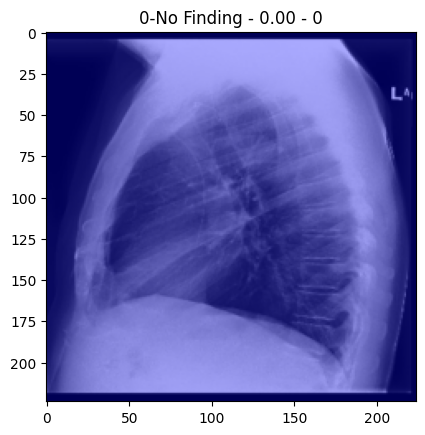

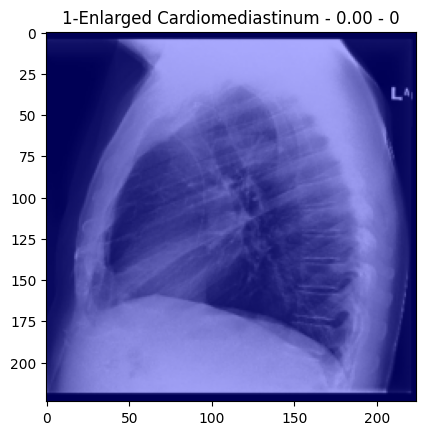

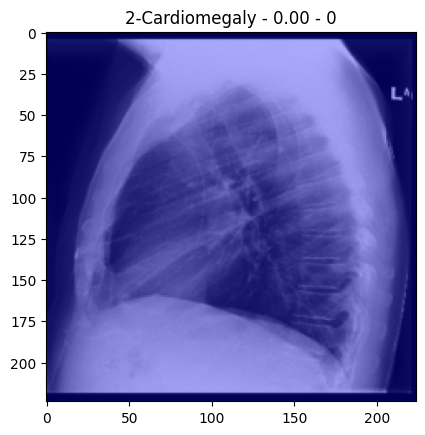

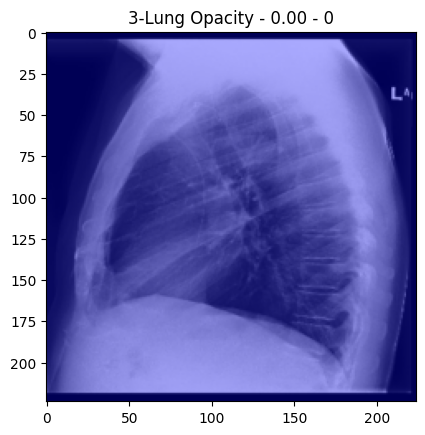

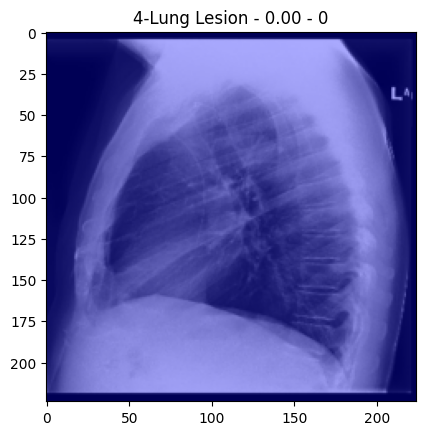

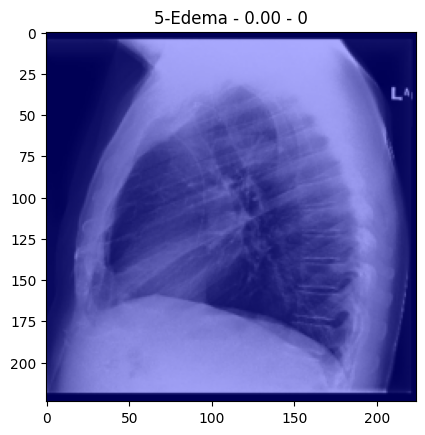

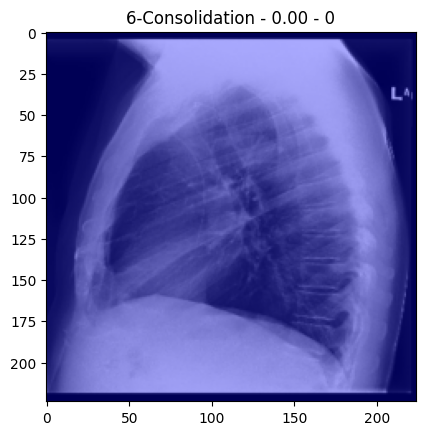

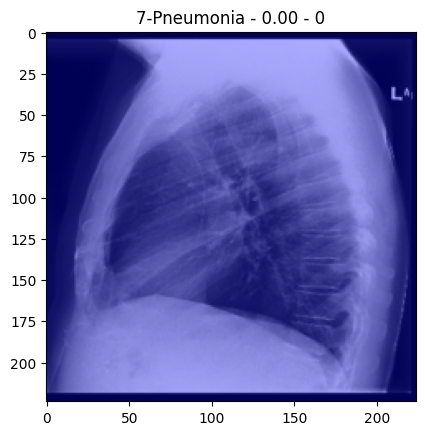

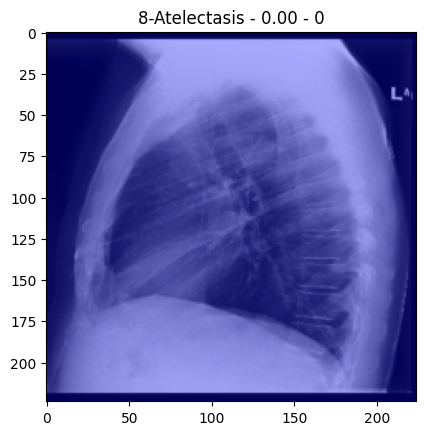

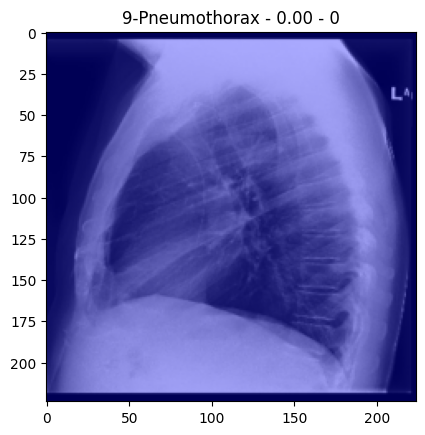

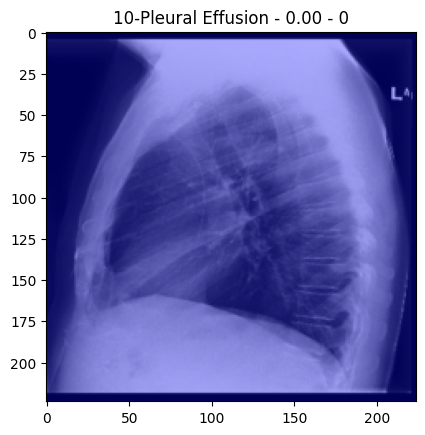

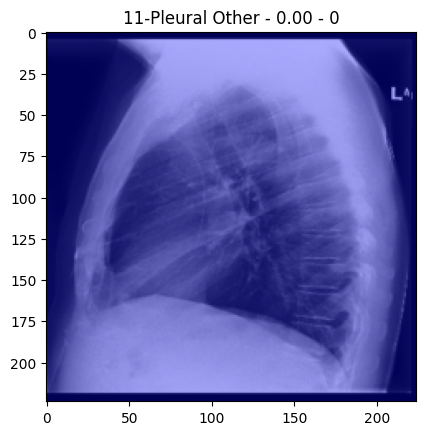

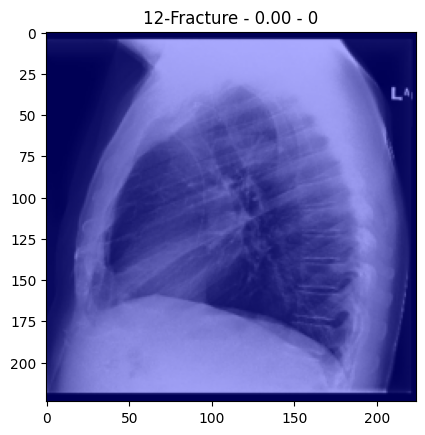

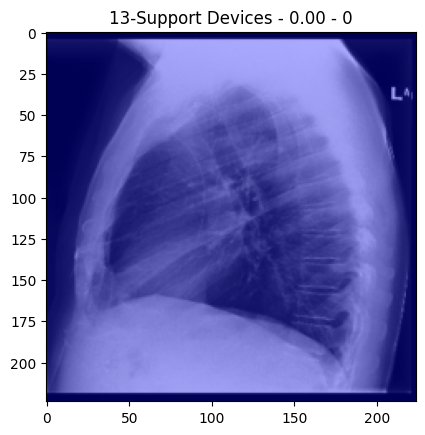

In [59]:
propabilities, predictions = get_results(image, logits)
# Plot the images
for i, cam_image in enumerate(cam_images):
    plt.imshow(cam_image)
    plt.title(f"{i}-{label_names[i]} - {propabilities[0][i]:.2f} - {predictions[0][i]}")
    plt.show()